In [19]:
import torch
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F
import lightning
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
import utils
import numpy as np
import matplotlib.pyplot as plt



In [20]:
class LSTMModel(lightning.LightningModule):
    def __init__(self, input_size, hidden_size, num_layers, learning_rate):
        super().__init__()
        self.lr = learning_rate
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
        self.criterion = nn.MSELoss()

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out)
        return out[:,-1,:].squeeze(-1)

    def training_step(self, batch, batch_idx):
        x, y = batch
        out = self(x)
        loss = self.criterion(out, y)
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        out = self(x)
        loss = self.criterion(out, y)
        self.log("val_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer


In [21]:
def create_sequences(x, y, seq_length):
    xs = []
    ys = []
    for i in range(len(x) - seq_length - 1):
        _x = x[i : i + seq_length]
        _y = y[i+seq_length]
        xs.append(_x)
        ys.append(_y)
    return np.array(xs), np.array(ys)


In [22]:
df_train, df_test, df_valid = utils.load_cleaned_data()

class ClimateDataset(torch.utils.data.Dataset):
    def __init__(self, df, seq_length) -> None:
        super().__init__()
        self.df = df
        self.x = df.iloc[:, 1:].values
        self.y = df.iloc[:, 0].values
        self.sequences, self.targets = create_sequences(self.x, self.y, seq_length)

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, index):
        x = self.sequences[index]
        y = self.targets[index]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

BATCH_SIZE = 32
SEQ_LENGTH = 2

dataloader_train = torch.utils.data.DataLoader(ClimateDataset(df_train, SEQ_LENGTH), batch_size=BATCH_SIZE, shuffle=False, num_workers=15)
dataloader_test = torch.utils.data.DataLoader(ClimateDataset(df_test, SEQ_LENGTH), batch_size=BATCH_SIZE, shuffle=False, num_workers=15)
dataloader_valid = torch.utils.data.DataLoader(ClimateDataset(df_valid, SEQ_LENGTH), batch_size=BATCH_SIZE, shuffle=False, num_workers=15)


In [23]:
model = LSTMModel(input_size=3, hidden_size=100, num_layers=5, learning_rate=0.01)
model


LSTMModel(
  (lstm): LSTM(3, 100, num_layers=5, batch_first=True)
  (fc): Linear(in_features=100, out_features=1, bias=True)
  (criterion): MSELoss()
)

In [24]:
trainer = lightning.Trainer(
    max_epochs=1000, 
    log_every_n_steps=1,
    callbacks=[EarlyStopping(monitor="val_loss", mode="min", patience=10)]
    )
trainer.fit(model, dataloader_train, dataloader_valid)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type    | Params
--------------------------------------
0 | lstm      | LSTM    | 365 K 
1 | fc        | Linear  | 101   
2 | criterion | MSELoss | 0     
--------------------------------------
365 K     Trainable params
0         Non-trainable params
365 K     Total params
1.461     Total estimated model params size (MB)


In [25]:
# trainer.test(model, dataloader_test)
dataloader_test = torch.utils.data.DataLoader(ClimateDataset(df_test, SEQ_LENGTH), batch_size=BATCH_SIZE, shuffle=False, num_workers=15)

# trainer.predict(model, dataloader_test)
preds = []
true = []
ds = ClimateDataset(df_test, SEQ_LENGTH)
for i in range(len(ds)):

    x, y = ds[i]
    pred = model.forward(x.unsqueeze(0))
    preds.append(pred.detach().numpy()[0])
    true.append(y.detach().numpy())


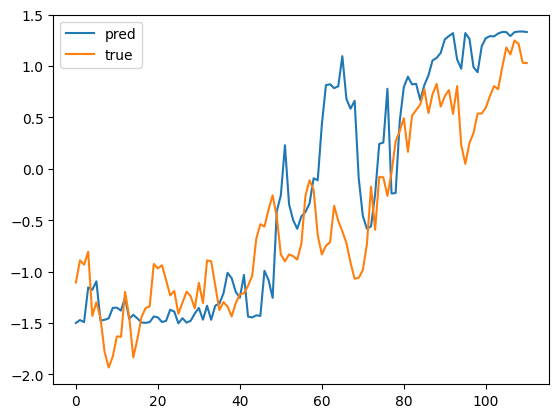

In [26]:

plt.plot(preds, label="pred")
plt.plot(true, label="true")
plt.legend()
plt.show()


In [29]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(true, preds)
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", np.sqrt(mse))



Mean Squared Error: 0.37031394
